In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.signal import decimate

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator

/Users/yuhan/work/nanospheres/dm_nanospheres/analysis_notebooks/../analysis_utils.py:451: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev, gauss(xx*amp2kev, *gps_normalized), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps_normalized[2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/dm_nanospheres/analysis_notebooks/../analysis_utils.py:453: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx*amp2kev, gauss(xx*amp2kev, *gps_normalized), label=f'{pulseamps[i]} keV, $\sigma$ = {gps_normalized[2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/dm_nanospheres/analysis_notebooks/../analysis_utils.py:458: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV (noise), $\sigma$ = {gps[i][2]:.1f} keV', color=color)
/Users/yuhan/work/nanospheres/dm_nanospheres/analysis_notebooks/../analysis_utils.py:460: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(xx, gauss(xx, *gps[i]), label=f'{pulseamps[i]} keV

## Look at events rejected by the $\chi^2$ test

In [2]:
def get_normalized_template(sphere, voltage, bounds=(1000, 2000), downsampled=False):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']
    pulse_shape_template = np.mean(pulse_shapes, axis=0)

    normalized_template = pulse_shape_template / np.max(pulse_shape_template)

    # Take the central values around the peak
    ret = normalized_template[bounds[0]:bounds[1]]

    if downsampled:
        ret_downsampled = decimate(ret, 10)
        return ret_downsampled / np.max(ret_downsampled)
    else:
        return ret

def get_idx_in_window(amp_searched_idx, search_length, lb):
    ret = np.empty_like(amp_searched_idx)

    for i, amp_idx in enumerate(amp_searched_idx):
        ret[i] = amp_idx + lb + search_length * i
    
    return ret

def calc_chisquares(amp_lp, indices_in_window, normalized_template, sigma_amp):
    ret = np.empty(indices_in_window.shape, np.float64)

    window_size = int(normalized_template.size / 2)
    for i, idx in enumerate(indices_in_window):
        amp = amp_lp[idx]
        waveform = amp_lp[idx-window_size : idx+window_size]

        # Amplitude can be negative so no need to adjust for polarity
        template_scaled = amp * normalized_template

        # Sigma should be in amplitude (not keV)
        ret[i] = np.sum( ((waveform - template_scaled)/sigma_amp)**2 )
        
    return ret

In [3]:
normalized_template_downsampled_long = get_normalized_template('sphere_20250103', voltage=20, bounds=(1000, 2000), downsampled=True)
normalized_template_downsampled_short = get_normalized_template('sphere_20250103', voltage=20, bounds=(1250, 1750), downsampled=True)

In [4]:
file = r'/Volumes/LaCie/dm_data_processed_fullamp/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_4_processed.hdf5'
f = h5py.File(file, "r")

amps = f['data_processed']['amplitude'][:]
f.close()

In [5]:
sigma_p = 176.79818534573002
amp2kev = 7157.624533259538

lb, ub = 100, -50

amp_all          = np.empty(shape=(amps.shape[0], 194), dtype=np.float64)
chisquare_long   = np.empty(shape=(amps.shape[0], 194), dtype=np.float64)
chisquare_short  = np.empty(shape=(amps.shape[0], 194), dtype=np.float64)
amp_indices      = np.empty(shape=(amps.shape[0], 194), dtype=np.int16)

for j, amp_lp in enumerate(amps):
    amp_search = np.abs(amp_lp[lb:ub])
    amp_reshaped = np.reshape(amp_search, (int(amp_search.size/25), 25))

    amp_searched_idx = np.argmax(amp_reshaped, axis=1)
    amp_searched_idx_in_window = get_idx_in_window(amp_searched_idx, search_length=25, lb=lb)

    amp_indices[j] = amp_searched_idx_in_window
    amp_all[j] = amp_lp[amp_searched_idx_in_window]
    chisquare_long[j] = calc_chisquares(amp_lp, amp_searched_idx_in_window, normalized_template_downsampled_long, sigma_amp=sigma_p/amp2kev)
    chisquare_short[j] = calc_chisquares(amp_lp, amp_searched_idx_in_window, normalized_template_downsampled_short, sigma_amp=sigma_p/amp2kev)

0.024302405498281787
0.0056855670103092785


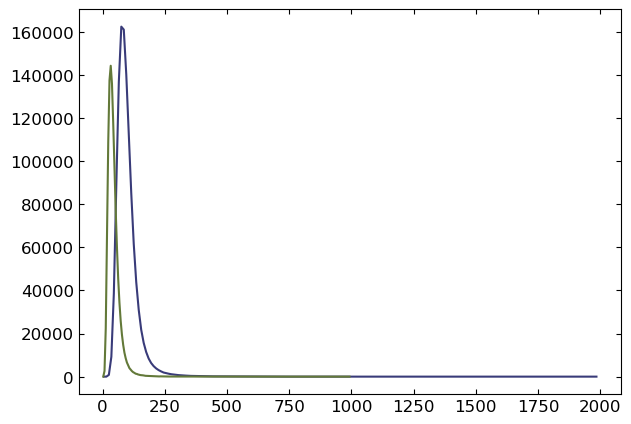

In [6]:
bins = np.arange(0, 2000, 10)
hh, be = np.histogram(chisquare_long.flatten(), bins=bins)
bc = 0.5 * (be[:-1] + be[1:])
plt.plot(bc, hh)

bins = np.arange(0, 1000, 5)
hh, be = np.histogram(chisquare_short.flatten(), bins=bins)
bc = 0.5 * (be[:-1] + be[1:])
plt.plot(bc, hh)

print(np.sum(chisquare_long > 200) / chisquare_long.size)
print(np.sum(chisquare_short > 150) / chisquare_short.size)

In [7]:
bad_chi2_long = np.asarray(np.nonzero(chisquare_long > 200)).T
bad_chi2_short = np.asarray(np.nonzero(chisquare_short > 150)).T

In [8]:
def get_amp_waveform(amps, amp_indices, bad_amp_idx, length=50):
    amps_window = amps[bad_amp_idx[0]]
    idx_in_window = amp_indices[*bad_amp_idx]
    ret = amps_window[idx_in_window-int(length/2) : idx_in_window+int(length/2)]

    return ret

In [9]:
bad_chi2_short.shape

(6618, 2)

315.15172697495916


Text(0.5, 0, 'Time (ms)')

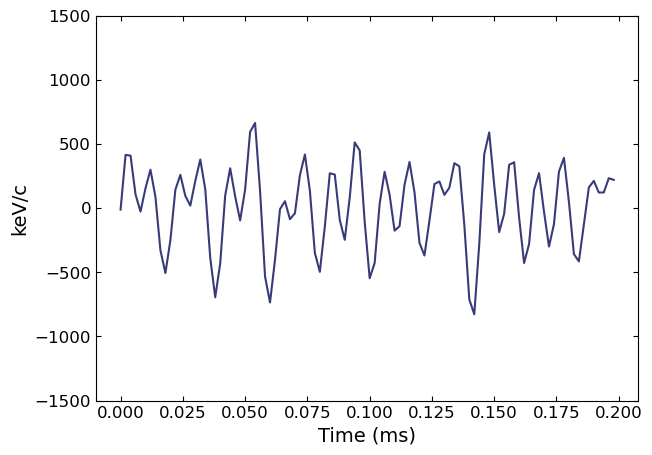

In [32]:
bad_idx = bad_chi2_long[2000]
print(chisquare_long[*bad_idx])
bad_waveform = get_amp_waveform(amps, amp_indices, bad_idx, length=100)

plt.plot(np.arange(0, 2e-6*bad_waveform.size, 2e-6)/1e-3, bad_waveform * amp2kev)
plt.ylim(-1500, 1500)
plt.ylabel('keV/c')
plt.xlabel('Time (ms)')

## Reconstruction

In [ ]:
def read_sphere_data(sphere):
    # data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'
    data_dir = r'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed'

    file = f'{data_dir}/sphere_data/{sphere}_recon_all_w_nocut.h5py'
    with h5py.File(file, 'r') as fout:
        g = fout['recon_data_all']

        hists, n_windows, scalings, rates, rate_errs = [], [], [], [], []
        for i in range(4):
            hists.append(g[f'hist_{i}'][:])
            n_windows.append(g[f'hist_{i}'].attrs['n_windows'])
            scalings.append(g[f'hist_{i}'].attrs['scaling'])

            rates.append(g[f'rate_hist_{i}'][:])
            rate_errs.append(g[f'rate_hist_err_{i}'][:])
        bc = g['bc'][:]

        fout.close()

    return bc, hists, n_windows, scalings, rates, rate_errs
    

In [ ]:
bc_0, hists_0, n_windows_0, scalings_0, rates_0, rate_errs_0 = read_sphere_data('sphere_20241202')
bc_1, hists_1, n_windows_1, scalings_1, rates_1, rate_errs_1 = read_sphere_data('sphere_20250103')

In [ ]:
print(f'Cut percentage (Sphere 20241202; DQ, NL, PS): {-1 * np.diff(np.asarray(n_windows_0)) / n_windows_0[0] * 100}')
print(f'Cut percentage (Sphere 20250103; DQ, NL, PS): {-1 * np.diff(np.asarray(n_windows_1)) / n_windows_1[0] * 100}')

Cut percentage (Sphere 20241202; DQ, NL, PS): [7.04848477e+00 6.40000539e-01 5.58130344e-03]
Cut percentage (Sphere 20250103; DQ, NL, PS): [3.27918567 1.41467842 0.011878  ]


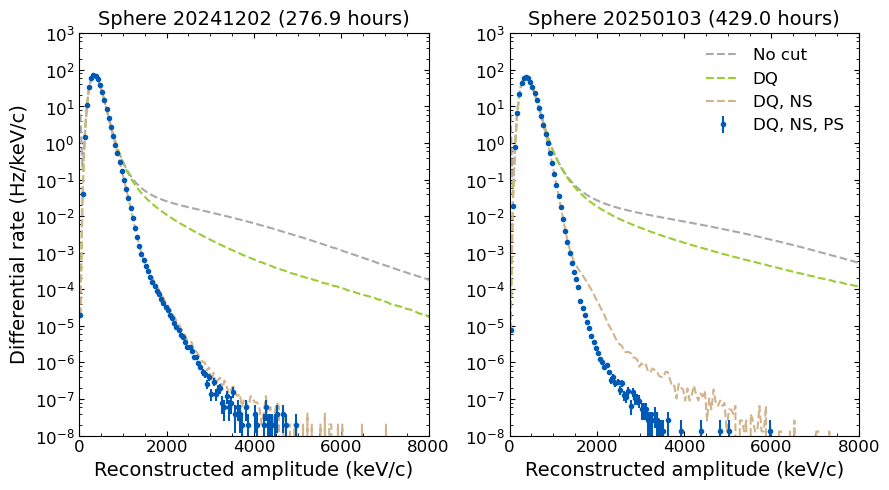

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

ax = axes[0]
ax.plot(bc_0, rates_0[0], '--', alpha=1, color='darkgrey')
ax.plot(bc_0, rates_0[1], '--', alpha=1, color='yellowgreen')
ax.plot(bc_0, rates_0[2], '--', alpha=1, color='tan')
ax.errorbar(bc_0, rates_0[3], yerr=rate_errs_0[3], fmt='.', color='#005AB5', alpha=1)

ax.set_title('Sphere 20241202 (276.9 hours)')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel('Differential rate (Hz/keV/c)')

ax = axes[1]
ax.plot(bc_1, rates_1[0], '--', alpha=1, label='No cut', color='darkgrey')
ax.plot(bc_1, rates_1[1], '--', alpha=1, label='DQ', color='yellowgreen')
ax.plot(bc_1, rates_1[2], '--', alpha=1, label='DQ, NS', color='tan')
ax.errorbar(bc_1, rates_1[3], yerr=rate_errs_1[3], fmt='.', color='#005AB5', alpha=1, label='DQ, NS, PS')

ax.set_title('Sphere 20250103 (429.0 hours)')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.legend(frameon=False)

for ax in axes:
    ax.set_yscale('log')
    # ax.set_xscale('log')

    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-8, 1000)

    ax.set_yticks(np.logspace(-8, 3, 12))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

fig.tight_layout()

In [3]:
## Calibration values for Sphere 20250103
c_mv = 8.263269630174246e-08
amp2kev = 7396.062147743912
sigma_p = 193.80085102332893  # keV/c

In [ ]:
def get_normalized_template(sphere, voltage, downsampled=False):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']
    pulse_shape_template = np.mean(pulse_shapes, axis=0)

    normalized_template = pulse_shape_template / np.max(pulse_shape_template)

    # Take the central 0.2 ms around the peak
    ret = normalized_template[1000:2000]

    # Downsample to 500 kHz (so the 200 us template has 100 indices)
    if downsampled:
        ret_downsampled = decimate(ret, 10)
        return ret_downsampled / np.max(ret_downsampled)
    else:
        return ret

In [62]:
np.max(normalized_template_downsampled)

1.0

In [44]:
normalized_template_downsampled = get_normalized_template('sphere_20250103', 20, True)


In [4]:
file = r'/Volumes/LaCie/dm_data/sphere_20250103/20250111_1e-8mbar_8e_alignment1_long/20250111_d_0.hdf5'

f = h5py.File(file, "r")

dtt = f['data'].attrs['delta_t']
fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

In [6]:
window_length = 5000

zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)
zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

In [77]:
_zz_bp = zz_bp_shaped[5]
_amp, amp_lp, temp = utils.recon_force(dtt, _zz_bp, c_mv)

lb, ub = 100, -50
amp_search = np.abs(amp_lp[lb:ub])
amp_reshaped = np.reshape(amp_search, (int(amp_search.size/25), 25))
amp_searched = np.max(amp_reshaped, axis=1)

In [78]:
amp_searched_idx = np.argmax(amp_reshaped, axis=1)

In [80]:
def get_idx_in_window(amp_searched_idx, search_length, lb):
    ret = np.empty_like(amp_searched_idx)

    for i, amp_idx in enumerate(amp_searched_idx):
        ret[i] = amp_idx + lb + search_length*i
    
    return ret

In [90]:
amp_searched_idx_in_window.shape

(194,)

In [82]:
amp_searched_idx_in_window = get_idx_in_window(amp_searched_idx, 25, 100)

In [ ]:
def calc_chisquares(amp_lp, indices_in_window, normalized_template, sigma_amp):
    ret = np.empty(indices_in_window.shape, np.float64)

    for i, idx in enumerate(indices_in_window):
        amp = amp_lp[idx]
        waveform = amp_lp[idx-50 : idx+50]

        # Amplitude can be negative so no need to ajust for polarity
        template_scaled = amp * normalized_template

        # Sigma should be in amplitude (not keV)
        ret[i] = np.sum( ((waveform - template_scaled)/sigma_amp)**2 )
        
    return ret

In [87]:
chisquares = calc_chisquares(amp_lp, amp_searched_idx_in_window, normalized_template_downsampled, sigma_p/amp2kev)

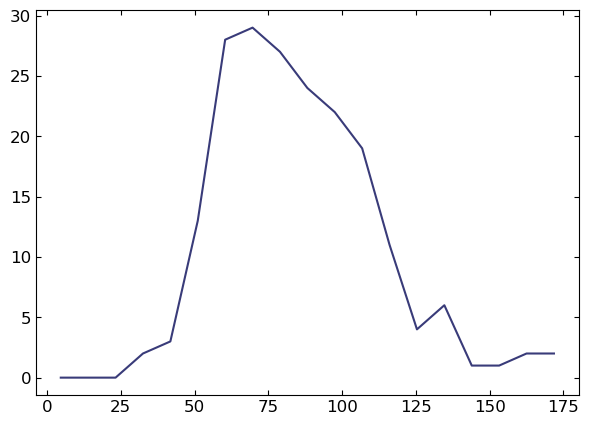

In [89]:
bins = np.linspace(0, np.max(chisquares), 20)
hh, be = np.histogram(chisquares, bins)
bc = 0.5 * (be[1:] + be[:-1])

plt.plot(bc, hh)

In [84]:
amp_lp[amp_searched_idx_in_window]

array([ 0.08772101,  0.05669152, -0.06897341,  0.05653008, -0.07798194,
        0.03708756,  0.04993439, -0.06371964, -0.03841992, -0.04374218,
        0.06077316, -0.03494775, -0.05947568, -0.06498815, -0.02708954,
        0.04122268,  0.05684673,  0.02078069,  0.03954533, -0.05486119,
       -0.05598166,  0.08086065, -0.05981752,  0.06866513,  0.04300902,
       -0.04741949,  0.03981559,  0.04895975, -0.038152  ,  0.05438   ,
       -0.06760482, -0.06856493,  0.04958079,  0.04539088,  0.06018391,
       -0.0465434 , -0.05463856, -0.04855631,  0.03943739,  0.0618602 ,
        0.07207361, -0.0671569 ,  0.06149261, -0.06339936,  0.05176493,
        0.02132841, -0.04797946,  0.05793515, -0.05199201,  0.03747432,
        0.05914015, -0.03919056, -0.03902831, -0.04452541,  0.04742779,
       -0.06319027,  0.0464343 ,  0.06232497,  0.06121025,  0.04674837,
        0.05277347, -0.04732615,  0.04276151,  0.01767062,  0.03503062,
       -0.03522466,  0.06469446, -0.06731397, -0.05377975, -0.02

In [83]:
amp_searched

array([0.08772101, 0.05669152, 0.06897341, 0.05653008, 0.07798194,
       0.03708756, 0.04993439, 0.06371964, 0.03841992, 0.04374218,
       0.06077316, 0.03494775, 0.05947568, 0.06498815, 0.02708954,
       0.04122268, 0.05684673, 0.02078069, 0.03954533, 0.05486119,
       0.05598166, 0.08086065, 0.05981752, 0.06866513, 0.04300902,
       0.04741949, 0.03981559, 0.04895975, 0.038152  , 0.05438   ,
       0.06760482, 0.06856493, 0.04958079, 0.04539088, 0.06018391,
       0.0465434 , 0.05463856, 0.04855631, 0.03943739, 0.0618602 ,
       0.07207361, 0.0671569 , 0.06149261, 0.06339936, 0.05176493,
       0.02132841, 0.04797946, 0.05793515, 0.05199201, 0.03747432,
       0.05914015, 0.03919056, 0.03902831, 0.04452541, 0.04742779,
       0.06319027, 0.0464343 , 0.06232497, 0.06121025, 0.04674837,
       0.05277347, 0.04732615, 0.04276151, 0.01767062, 0.03503062,
       0.03522466, 0.06469446, 0.06731397, 0.05377975, 0.02767778,
       0.0496261 , 0.05997322, 0.03546387, 0.04564219, 0.03642

In [79]:
amp_searched_idx

array([18,  0, 12, 21,  5, 24,  6, 13, 14,  5,  3,  2, 12, 13, 24,  3,  1,
        8, 11, 22, 22,  0, 21,  0,  0, 23,  1, 20, 11, 11,  0, 10,  2, 16,
        6, 12,  4, 17, 13, 24,  6, 24,  3, 23,  2, 15, 22,  0, 20,  2, 16,
       14, 17, 10,  9,  7,  6, 10,  1,  8, 20,  5,  9, 13, 22, 21, 23, 24,
        0,  4, 24,  0,  0, 14,  7, 10, 12,  6,  2, 24,  8, 11, 23, 23,  5,
       23,  1, 24,  3, 19, 16,  1, 13, 11,  6, 15, 10,  9, 15, 24, 18, 11,
        9, 10,  3,  9,  9,  7, 23,  1, 11, 17,  7,  8, 22,  1, 14, 24,  0,
       21, 20, 14, 22,  8,  7, 21,  2, 19,  5,  5, 17, 11, 14, 24,  2, 11,
       12, 14,  7,  2, 15, 12,  3, 11,  5, 17, 11,  9, 17, 20, 24,  4, 16,
       12, 10,  8, 21, 16, 17,  6, 12,  9,  5, 22, 20,  7,  3,  4,  4,  6,
       24,  7, 18,  7,  2,  5, 16,  6, 12,  9,  1, 16,  9, 11,  6,  1, 24,
        2,  7,  5, 18,  6, 17,  7])

In [ ]:
amp_reshaped[amp_searched_idx]

TypeError: only integer scalar arrays can be converted to a scalar index

In [75]:
np.take(amp_reshaped, amp_searched_idx, axis=0).shape

(194, 25)

In [74]:
amp_reshaped.shape

(194, 25)

In [60]:
amp_searched.shape

(194,)

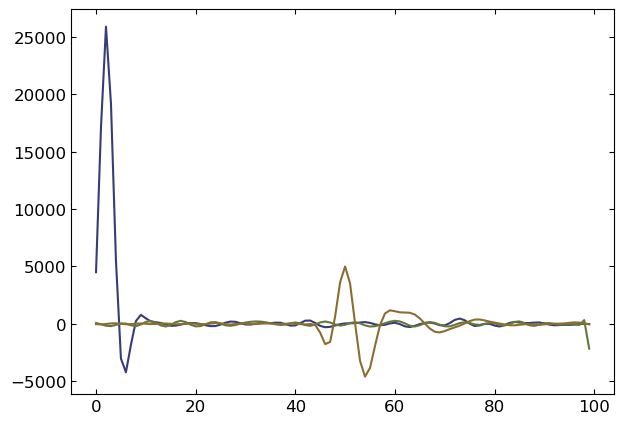

In [57]:
plt.plot(amp_lp[:100] * amp2kev )
plt.plot(amp_lp[-100:] * amp2kev )
plt.plot(normalized_template_downsampled*5000)

# plt.ylim(-1000, 1000)

In [51]:
200 / 5000

0.04

In [114]:
file = r'/Volumes/Expansion/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_100_processed.hdf5'

fout = h5py.File(file, "r")
g = fout['data_processed']

amp = g['amplitude'][:]
chi2 = g['chisquare'][:]
indices = g['idx_in_window'][:]

In [120]:
amp.size

1164000

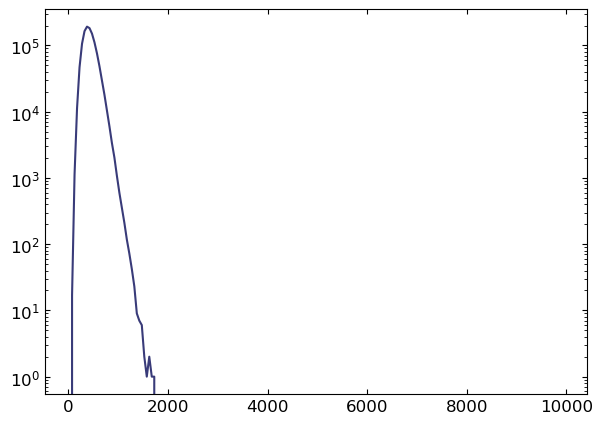

In [115]:
bins = np.arange(0, 10000, 50)  # keV
bc = 0.5 * (bins[:-1] + bins[1:])

hh, be = np.histogram(np.abs(amp.flatten())*amp2kev, bins)

plt.plot(bc, hh)
plt.yscale('log')

(0.0, 2500.0)

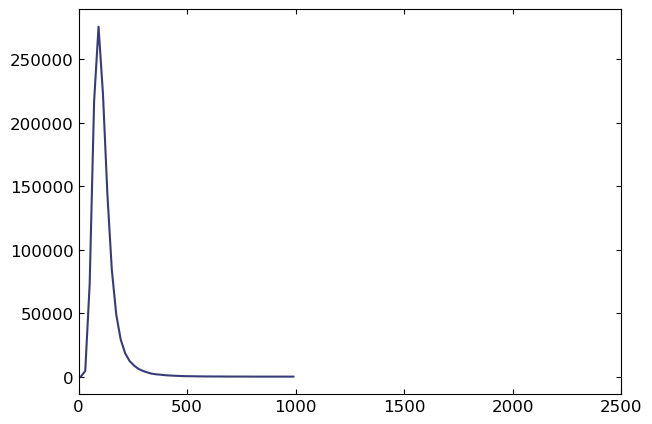

In [121]:
bins = np.linspace(0, 1000, 50)
hh, be = np.histogram(chi2.flatten(), bins)
bc = 0.5 * (be[1:] + be[:-1])

plt.plot(bc, hh)
plt.xlim(0, 2500)